## NUS Deep Learning workshop on computer vision

### What is TensorFlow
* A system for executing computational graphs over Tensor objects - n-dimensional arrays analogous to the numpy ndarray.
* Native support for performing backpropogation for its Variables. 
* Used by Google for both research and production. 

### Why use Tensorflow

* Save you a lot of time when buiding large computational graphs - can automatically compute gradients to update weights!
* Code can be run on GPU - usually 5x - 20x times faster than CPU for usually image networks. And you don't need to worry about low level cuda-code, things are taken care for you in tf. 
* A lot of good high level APIs or pre-trained models that you can use directly. 

## A brief example of tensorflow  

### Graph building blocks: 
1) Placeholder: input nodes to our graph, which serve as entry points where we can feed data into graph - `tf.placeholder`

2) Variables: tensors that hold values in the graph, which will be updated during training - `tf.Variable`

3) Ops: arithmetic operators, as well as activation, convolution, loss ops and many more - 
* a = tf.constant([3, 6])
* b = tf.constant([2, 2])
* tf.add(a, b) # >> [5 8]
* tf.add_n([a, b, b]) # >> [7 10]. Equivalent to a + b + b
* tf.mul(a, b) # >> [6 12] because mul is element wise
* tf.matmul(a, b) # >> ValueError
* tf.matmul(tf.reshape(a, shape=[1, 2]), tf.reshape(b, shape=[2, 1])) # >> [[18]]
* tf.div(a, b) # >> [1 3]
* tf.mod(a, b) # >> [1 0]

* tf.nn*, such as tf.nn.conv2d, tf.nn.max_pool, tf.nn.softmax, tf.nn.relu, and so on

4) tf.train* subclasses: Optimizer base classes that compute gradients for a loss and apply gradients to variables. Such as tf.train.GradientDescentOptimizer, tf.train.AdadeltaOptimizer, etc.

### 1) Build the graph 

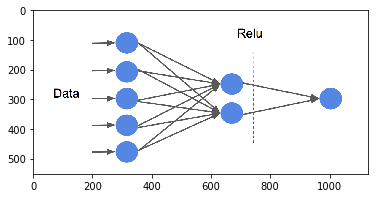

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
img = plt.imread('./images/LM.png')
plt.imshow(img)

In [2]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()

N = 128 # sample size 
D = 5 # data dimension 
H = 2 # hidden layer dimension 

x = tf.placeholder(tf.float32, shape=(N, D), name = 'input')
y = tf.placeholder(tf.float32, shape=(N, 1), name = 'target')

# all weights for model 
w1 = tf.Variable(tf.random_normal((D, H)), name = 'weights1')
b1 = tf.Variable(tf.zeros([2]), name = 'biases1')
w2 = tf.Variable(tf.random_normal((H, 1)), name = 'weights2')
b2 = tf.Variable(tf.zeros([1]), name = 'biases1')

# relu hidden layer
h = tf.maximum(tf.matmul(x, w1) + b1, 0)

# output layer 
y_pred = tf.matmul(h, w2) + b2

# loss 
loss = tf.reduce_mean((y_pred - y)**2)

# update 
optimizer = tf.train.GradientDescentOptimizer(1e-3)
updates = optimizer.minimize(loss)


In [3]:
tf.trainable_variables()

[<tf.Variable 'weights1:0' shape=(5, 2) dtype=float32_ref>,
 <tf.Variable 'biases1:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'weights2:0' shape=(2, 1) dtype=float32_ref>,
 <tf.Variable 'biases1_1:0' shape=(1,) dtype=float32_ref>]

### 2) Train the model

In [4]:
data_x = np.random.randn(N, D)
data_y = np.random.randn(N, 1)

data = {x: data_x, 
        y: data_y}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    losses = []
    for t in range(1000):
        loss_val, _  = sess.run([loss, updates], 
                                feed_dict = data)
        losses.append(loss_val)

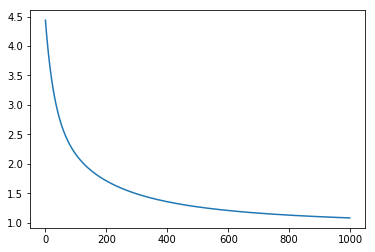

In [5]:
plt.plot(losses)

### 3) Can switch to high-level layers too

In [6]:
# reset the graph
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(N, D), name = 'input')
y = tf.placeholder(tf.float32, shape=(N, 1), name = 'target')

# weights initializer
init = tf.contrib.layers.xavier_initializer()

# hidden layer
h = tf.layers.dense(inputs=x, units=H, 
                    activation=tf.nn.relu, 
                    kernel_initializer = init, 
                    name='hidden_layer')

# output layer
y_pred = tf.layers.dense(inputs=h, units=1, 
                        kernel_initializer = init, 
                        name='output_layer')

# loss
loss = tf.losses.mean_squared_error(y_pred, y)

# updates
optimizer = tf.train.GradientDescentOptimizer(1e-3)
updates = optimizer.minimize(loss)


In [7]:
data = {x: data_x, 
        y: data_y}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    losses = []
    for t in range(1000):
        loss_val, _  = sess.run([loss, updates], 
                                feed_dict = data)
        losses.append(loss_val)


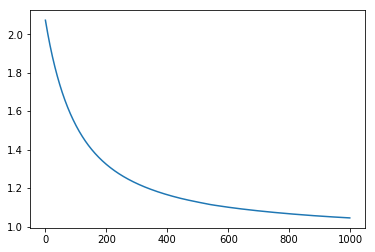

In [8]:
plt.plot(losses)

### 4) Save and test your model

### Train and save - save all the weights of our graph!

In [9]:
saver = tf.train.Saver()

data = {x: data_x, 
        y: data_y}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    losses = []
    for t in range(1000):
        loss_val, _  = sess.run([loss, updates], 
                                feed_dict = data)
        losses.append(loss_val)
        
    saved_path = saver.save(sess, '/Users/weimin/Desktop/workshop/testing.ckpt')
print("Final loss is: {} and model saved at: {}".format(losses[-1], saved_path))

Final loss is: 0.9991867542266846 and model saved at: /Users/weimin/Desktop/workshop/testing.ckpt


### Test it!

In [10]:
# First, we have to rebuild the graph
# reset the graph
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=(N, D), name = 'input')
y = tf.placeholder(tf.float32, shape=(N, 1), name = 'target')

# weights initializer
init = tf.contrib.layers.xavier_initializer()

# hidden layer
h = tf.layers.dense(inputs=x, units=H, 
                    activation=tf.nn.relu, 
                    kernel_initializer = init, 
                    name='hidden_layer')

# output layer
y_pred = tf.layers.dense(inputs=h, units=1, 
                        kernel_initializer = init, 
                        name='output_layer')

# loss
loss = tf.losses.mean_squared_error(y_pred, y)

saver = tf.train.Saver()


# Second, load the weights from your previously trained model, and test on your data
data = {x: data_x, 
        y: data_y}

with tf.Session() as sess:
    # Restore model weights from previously saved model
    saver.restore(sess, saved_path)
    
    final_loss = sess.run(loss, feed_dict = data)
print(final_loss)

INFO:tensorflow:Restoring parameters from /Users/weimin/Desktop/workshop/testing.ckpt
0.999152


## Create an image classifier using CNN

- `tf.nn.conv2d`: https://www.tensorflow.org/api_docs/python/tf/nn/conv2d
- `tf.layers.conv2d`: https://www.tensorflow.org/api_docs/python/tf/layers/conv2d
- `tf.contrib.layers.convolution2d`: https://www.tensorflow.org/api_guides/python/contrib.layers (not covered)
- `tf.nn.max_pool`: https://www.tensorflow.org/api_docs/python/tf/nn/max_pool

### 1) The hard way - using `tf.nn.conv2d` directly

In [11]:
tf.reset_default_graph()
# input image shape is [batch_size, height, width, channels]
input_image = tf.placeholder(tf.float32, [None, 32, 32, 3])

def conv2d(x, W):
  """conv2d returns a 2d convolution layer with full stride."""
  return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def weight_variable(shape, name = None):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name = name)

def bias_variable(shape, name = None):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name = name)

W_conv = weight_variable([5, 5, 3, 64], name = 'W') # [filter_height, filter_width, in_channels, out_channels]
b_conv = bias_variable([64], name = 'b')
h_conv = tf.nn.relu(conv2d(input_image, W_conv) + b_conv)

In [12]:
h_conv

<tf.Tensor 'Relu:0' shape=(?, 32, 32, 64) dtype=float32>

In [13]:
tf.trainable_variables()

[<tf.Variable 'W:0' shape=(5, 5, 3, 64) dtype=float32_ref>,
 <tf.Variable 'b:0' shape=(64,) dtype=float32_ref>]

### 2) The easy way

In [14]:
tf.reset_default_graph()
# input image shape is [batch_size, height, width, channels]
input_image = tf.placeholder(tf.float32, [None, 32, 32, 3])

h_conv = tf.layers.conv2d(
  inputs=input_image,
  filters=64,
  kernel_size=[5, 5],
  padding="same",
  kernel_initializer=tf.truncated_normal_initializer,
  activation=tf.nn.relu)

In [15]:
h_conv

<tf.Tensor 'conv2d/Relu:0' shape=(?, 32, 32, 64) dtype=float32>

In [16]:
tf.trainable_variables()

[<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 3, 64) dtype=float32_ref>,
 <tf.Variable 'conv2d/bias:0' shape=(64,) dtype=float32_ref>]

### 3) Pooling layer

In [17]:
h_pool1 = tf.nn.max_pool(h_conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
h_pool1

<tf.Tensor 'MaxPool:0' shape=(?, 16, 16, 64) dtype=float32>

## Example - CNN of a toy image

### Input - 5 images

In [18]:
tf.reset_default_graph()

image_input = tf.constant([
            [
                [[1., 1., 1.], [1., 1., 1.], [1., 1., 1.], [1., 1., 1.]],
                [[1., 1., 1.], [1., 1., 1.], [1., 1., 1.], [1., 1., 1.]],
                [[254., 0., 0.], [255., 255., 255.], [0., 0., 0.], [0., 0., 0.]], 
                [[254., 0., 0.], [255., 255., 255.], [0., 0., 0.], [0., 0., 0.]]
            ], 
    
            [
                [[1., 1., 1.], [1., 1., 1.], [1., 1., 1.], [1., 1., 1.]],
                [[1., 1., 1.], [1., 1., 1.], [1., 1., 1.], [1., 1., 1.]],
                [[254., 0., 0.], [255., 255., 255.], [0., 0., 0.], [0., 0., 0.]], 
                [[254., 0., 0.], [255., 255., 255.], [0., 0., 0.], [0., 0., 0.]]
            ], 
    
            [
                [[1., 1., 1.], [1., 1., 1.], [1., 1., 1.], [1., 1., 1.]],
                [[1., 1., 1.], [1., 1., 1.], [1., 1., 1.], [1., 1., 1.]],
                [[254., 0., 0.], [255., 255., 255.], [0., 0., 0.], [0., 0., 0.]], 
                [[254., 0., 0.], [255., 255., 255.], [0., 0., 0.], [0., 0., 0.]]
            ], 
            [
                [[1., 1., 1.], [1., 1., 1.], [1., 1., 1.], [1., 1., 1.]],
                [[1., 1., 1.], [1., 1., 1.], [1., 1., 1.], [1., 1., 1.]],
                [[254., 0., 0.], [255., 255., 255.], [0., 0., 0.], [0., 0., 0.]], 
                [[254., 0., 0.], [255., 255., 255.], [0., 0., 0.], [0., 0., 0.]]
            ], 
            [
                [[1., 1., 1.], [1., 1., 1.], [1., 1., 1.], [1., 1., 1.]],
                [[1., 1., 1.], [1., 1., 1.], [1., 1., 1.], [1., 1., 1.]],
                [[254., 0., 0.], [255., 255., 255.], [0., 0., 0.], [0., 0., 0.]], 
                [[254., 0., 0.], [255., 255., 255.], [0., 0., 0.], [0., 0., 0.]]
            ]
        ])
image_input

<tf.Tensor 'Const:0' shape=(5, 4, 4, 3) dtype=float32>

In [19]:
h_conv = tf.layers.conv2d(
  inputs=image_input,
  filters=2,
  kernel_size=[1, 1],
  padding="same",
  kernel_initializer=tf.truncated_normal_initializer,
  activation=tf.nn.relu)
h_pool = tf.layers.max_pooling2d(inputs=h_conv, pool_size=[2, 2], strides=2)

In [20]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    h_conv_res = sess.run(h_conv)
    print(h_conv_res)
    print("Output tensor shape: ", h_conv_res.shape)

[[[[   1.06532812    0.        ]
   [   1.06532812    0.        ]
   [   1.06532812    0.        ]
   [   1.06532812    0.        ]]

  [[   1.06532812    0.        ]
   [   1.06532812    0.        ]
   [   1.06532812    0.        ]
   [   1.06532812    0.        ]]

  [[   0.            0.        ]
   [ 271.65869141    0.        ]
   [   0.            0.        ]
   [   0.            0.        ]]

  [[   0.            0.        ]
   [ 271.65869141    0.        ]
   [   0.            0.        ]
   [   0.            0.        ]]]


 [[[   1.06532812    0.        ]
   [   1.06532812    0.        ]
   [   1.06532812    0.        ]
   [   1.06532812    0.        ]]

  [[   1.06532812    0.        ]
   [   1.06532812    0.        ]
   [   1.06532812    0.        ]
   [   1.06532812    0.        ]]

  [[   0.            0.        ]
   [ 271.65869141    0.        ]
   [   0.            0.        ]
   [   0.            0.        ]]

  [[   0.            0.        ]
   [ 271.65869141    0.    

In [21]:
h_pool

<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(5, 2, 2, 2) dtype=float32>

### 5) Flatten last pooling 1-D vector

In [22]:
flatten_dim = h_pool.get_shape().as_list()[1] * h_pool.get_shape().as_list()[2] * h_pool.get_shape().as_list()[3]
h_pool_flat = tf.reshape(h_pool, [-1, flatten_dim])
h_pool_flat

<tf.Tensor 'Reshape:0' shape=(5, 8) dtype=float32>

### 6) FC layer 

In [24]:
with tf.name_scope('fc1'):
    W_fc1 = weight_variable([flatten_dim, 2], name = 'W')
    b_fc1 = bias_variable([2], name = 'b')
h_fc1 = tf.matmul(h_pool_flat, W_fc1) + b_fc1

In [25]:
h_fc1

<tf.Tensor 'add:0' shape=(5, 2) dtype=float32>

### 7) Batch norm (optional)

In [26]:
def batch_norm(h, is_training):
    return tf.contrib.layers.batch_norm(h, 
                                        center=True, 
                                        scale=True, 
                                        is_training=is_training)
h_fc1_batchnorm = batch_norm(h_fc1, is_training=True)

### 8) Loss function

In [27]:
loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.constant([[1,0], 
                                                                   [1,0], 
                                                                   [0,1], 
                                                                   [0,1], 
                                                                   [1,0]]),
                                               logits=h_fc1)
loss = tf.reduce_mean(loss)

### 9) Training Step 

In [28]:
train_step = tf.train.AdamOptimizer(0.001).minimize(loss)

In [29]:
tf.trainable_variables()

[<tf.Variable 'conv2d/kernel:0' shape=(1, 1, 3, 2) dtype=float32_ref>,
 <tf.Variable 'conv2d/bias:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'fc1/W:0' shape=(8, 2) dtype=float32_ref>,
 <tf.Variable 'fc1/b:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'BatchNorm/beta:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'BatchNorm/gamma:0' shape=(2,) dtype=float32_ref>]

### 10) Prediction and accuracy 

In [30]:
logits = h_fc1
y_target = np.array([[1,0], 
                     [1,0], 
                     [0,1], 
                     [0,1], 
                     [1,0]])
probs = tf.nn.softmax(logits)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_target, 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

In [31]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    accuracy = sess.run(accuracy)

In [32]:
print('Accuracy for a random prediction: ', accuracy)

Accuracy for a random prediction:  0.6


## The whole script for building graph - to understand ```train.py```

### 1) Build the CNN graph 

In [40]:
def build_graph(config):
    """This function builds the graph for a deep net for classifying images.
    Args:
      config: Model configuration object
    Returns:
      A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
      equal to the logits of classifying the image into one of 10 classes (the
      digits 0-9). keep_prob is a scalar placeholder for the probability of
      dropout.
    """

    x_image = tf.placeholder(tf.float32, [None, config.image_height, config.image_width, config.image_channels])
    y = tf.placeholder(tf.float32, [None, int(config.num_classes)])
    is_training = tf.placeholder(tf.bool, [])
    keep_prob = tf.placeholder(tf.float32)

    # First convolutional module [conv-conv-pool] -- maps one grayscale image to 32 feature maps.
    with tf.name_scope('conv1_1'):
        W_conv1_1 = weight_variable([config.filter_size, config.filter_size, config.image_channels, config.conv1_num_filters], name = 'W')
        b_conv1_1 = bias_variable([config.conv1_num_filters], name = 'b')
        c_conv1_1 = conv2d(x_image, W_conv1_1) + b_conv1_1
        #c_conv1_1 = batch_norm1(c_conv1_1, is_training)
        h_conv1_1 = tf.nn.relu(c_conv1_1)

    with tf.name_scope('conv1_2'):
        W_conv1_2 = weight_variable([config.filter_size, config.filter_size, config.conv1_num_filters, config.conv1_num_filters], name = 'W')
        b_conv1_2 = bias_variable([config.conv1_num_filters], name = 'b')
        c_conv1_2 = conv2d(h_conv1_1, W_conv1_2) + b_conv1_2
        #c_conv1_2 = batch_norm1(c_conv1_2, is_training)
        h_conv1_2 = tf.nn.relu(c_conv1_2)

    # Pooling layer - downsamples by 2X.
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1_2)

    # Second convolutional module [conv-conv-pool] -- maps 32 feature maps to 64.
    with tf.name_scope('conv2_1'):
        W_conv2_1 = weight_variable([config.filter_size, config.filter_size, config.conv1_num_filters, config.conv2_num_filters], name = 'W')
        b_conv2_1 = bias_variable([config.conv2_num_filters], name = 'b')
        c_conv2_1 = conv2d(h_pool1, W_conv2_1) + b_conv2_1
        #c_conv2_1 = batch_norm1(c_conv2_1, is_training)
        h_conv2_1 = tf.nn.relu(c_conv2_1)

    with tf.name_scope('conv2_2'):
        W_conv2_2 = weight_variable([config.filter_size, config.filter_size, config.conv2_num_filters, config.conv2_num_filters], name = 'W')
        b_conv2_2 = bias_variable([config.conv2_num_filters], name = 'b')
        c_conv2_2 = conv2d(h_conv2_1, W_conv2_2) + b_conv2_2
        #c_conv2_2 = batch_norm1(c_conv2_2, is_training)
        h_conv2_2 = tf.nn.relu(c_conv2_2)
        
    # Second pooling layer.
    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv2_2)

    # Fully connected layer 1 -- after 2 round of downsampling, our 32x32 image
    # is down to 4x4x64 feature maps -- maps this to 1024 features.
    #feature_map_flattened_dim = int((config.image_height/(2**2)) * (config.image_width/(2**2)) * config.conv2_num_filters)
    feature_map_flattened_dim = int(np.prod(h_pool2.get_shape()[1:]))

    h_pool2_flat = tf.reshape(h_pool2, [-1, feature_map_flattened_dim])
    with tf.name_scope('fc1'):
        W_fc1 = weight_variable([feature_map_flattened_dim, config.fc1_num_features], name = 'W')
        b_fc1 = bias_variable([config.fc1_num_features], name = 'b')
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    with tf.name_scope('dropout1'):
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    """with tf.name_scope('fc2'):
        W_fc2 = weight_variable([config.fc1_num_features, config.fc2_num_features], name = 'W')
        b_fc2 = bias_variable([config.fc2_num_features], name = 'b')
    h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    #h_fc2 = batch_norm1(h_fc2, is_training)
    h_fc2 = tf.nn.relu(h_fc2)
    with tf.name_scope('dropout2'):
        h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)"""

    # Map the 1024 features to 10 classes, one for each digit
    with tf.name_scope('fc3'):
        W_fc3 = weight_variable([config.fc1_num_features, config.num_classes], name = 'W')
        b_fc3 = bias_variable([config.num_classes], name = 'b')
    
    # Raw predictions - logits
    with tf.name_scope('logits'):
        logits = tf.matmul(h_fc1_drop, W_fc3) + b_fc3

    with tf.name_scope('probabilities'):
        probs = tf.nn.softmax(logits)

    with tf.name_scope('loss'):
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=y,
                                                       logits=logits)
    loss = tf.reduce_mean(loss)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        with tf.name_scope('adam_optimizer'):
            train_step = tf.train.AdamOptimizer(config.learning_rate).minimize(loss)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

    saver = tf.train.Saver

    # Return the model in dict
    return dict(
        x_image = x_image, 
        y = y, 
        is_training = is_training, 
        keep_prob = keep_prob, 
        h_conv1_1 = h_conv1_1,
        logits = logits, 
        probs = probs, 
        loss = loss, 
        train_step = train_step, 
        accuracy = accuracy, 
        saver = saver, 
        )

### 2) Train the model

In [34]:
def train_model_for_one_epoch(iterations, train_x, train_y, model, sess, config, record_train_loss = False):

    num_images = len(train_x)
    for i in range(iterations):
        # Create a random index.
        idx = np.random.choice(num_images,
                               size=config.batch_size,
                               replace=False)
        batch_x = train_x[idx, :, :, :]
        batch_y = train_y[idx, :]

        
        _, temp_loss = sess.run([model['train_step'], model['loss']], feed_dict={model['x_image']: batch_x, \
                                                                                 model['y']: batch_y, \
                                                                                 model['is_training']: True, \
                                                                                 model['keep_prob']:config.keep_rate})
        if record_train_loss: 
            training_loss.append(temp_loss)


### 3) Model evaluation 

In [36]:
def generate_prediction(val_x, val_y, model, sess, list_to_pred):

    predictions = sess.run([model[p] for p in list_to_pred], feed_dict={model['x_image']: val_x, \
                                                                        model['y']: val_y, \
                                                                        model['is_training']: False, \
                                                                        model['keep_prob']: 1.0})
    return predictions

### 4) Visualization for loss accuracy


Train & val losses

<img src="images/train_losses.png" />

<img src="images/val_losses_n_accuracy.png" />

### 5) Visualize activations from images - cell below for explanation only, please don't run it :)

In [ ]:
idx = np.random.choice(train_data.shape[0],
      size=1,
      replace=False)
img = train_data[idx[0], :, :, :]
## visualize layer-1 kernel weights in grid 
img = np.expand_dims(img, 0)
h_conv1_1 = sess.run(model['h_conv1_1'], feed_dict={model['x_image']:img})
h_conv1_1 = h_conv1_1.transpose(3, 1, 2, 0)   # reshape to: (N, H, W, 1)
vis_grid = visualize_grid(h_conv1_1, grey = True)
plot_weights_in_grid(vis_grid, os.path.join(save_dir, 'vis_activations.png'))

<tr>
<td><img src="images/vis_acti_dog.png" /></td>
<td><img src="images/vis_acti_frog.png" /></td>
</tr>

## How to use the files: 
****`train.py`:****  To build & train the model, as well as to monitor the training progress and to visualize graphs like above. Upon completion, it will save the trained model into specified location. How to run:                        
`python train.py --trainDir /home/ubuntu/workshop/ --savedSessionDir /home/ubuntu/workshop/savedSessions/`

**** `build_graph.py`: ****  Build the model graph and return list of nodes to the graph

**** `configuration.py`: **** Configuration file for model and training. 

**** `vis_utils.py`: **** Visualization utility functions

**** `data_utils.py`: **** Data utility functions. 